In [1]:
# call __init_ to set notebook seed
import set_notebook_env
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import statsmodels.formula.api as smf
from scipy.stats import mannwhitneyu
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from utils.modeling_helpers import ModelHelper
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import StandardScaler 
from sklearn.decomposition import PCA

from collections import defaultdict
import numpy as np

import set_notebook_env
loader, plot_utils = set_notebook_env.set_env(
    data_dir="../data/", 
    min_ratings=0, 
    max_ratings=None,
    drop_inconsistent_gender = True
)

SEED = np.random.get_state()[1][0]

loader.initial_setup()
NUM_COLS = loader.num_cols + ['gender_code']

prepared_df = loader.prepared_df
prepared_df = loader.add_gender_code(loader.prepared_df)

MODEL_HELPER = ModelHelper(df=prepared_df, random_seed=SEED)

prepared_df.columns


Using seed: 18787288


Index(['avg_rating', 'avg_difficulty', 'num_ratings', 'pepper',
       'would_take_again_prop', 'num_online_ratings', 'male', 'female',
       'tough_grader', 'good_feedback', 'respected', 'lots_to_read',
       'participation_matters', 'no_skip', 'lots_of_hw', 'inspirational',
       'pop_quizzes', 'accessible', 'papers', 'clear_grading', 'hilarious',
       'test_heavy', 'few_things', 'amazing_lectures', 'caring',
       'extra_credit', 'group_projects', 'lecture_heavy', 'major',
       'university', 'state', 'gender_code'],
      dtype='object')

In [2]:

for col in NUM_COLS:
    print(f"{col} : {prepared_df[col].isna().sum()}")
    
tag_cols = [
    c for c in NUM_COLS
    if not any(g in c.lower() for g in ["would_take_again_prop", "female", "male"])
]


# has online rating 
prepared_df["has_online_ratings"] = np.where(
    prepared_df["num_online_ratings"] > 0, 1, 0
)

d = prepared_df[tag_cols + ["has_online_ratings"]].drop("num_online_ratings", axis = 1)

d.columns


avg_rating : 0
avg_difficulty : 0
num_ratings : 0
pepper : 0
would_take_again_prop : 43239
num_online_ratings : 0
male : 0
female : 0
gender_code : 0


Index(['avg_rating', 'avg_difficulty', 'num_ratings', 'pepper', 'gender_code',
       'has_online_ratings'],
      dtype='object')

Rows with >= 1 NA in tag cols: 0 (0.00%)


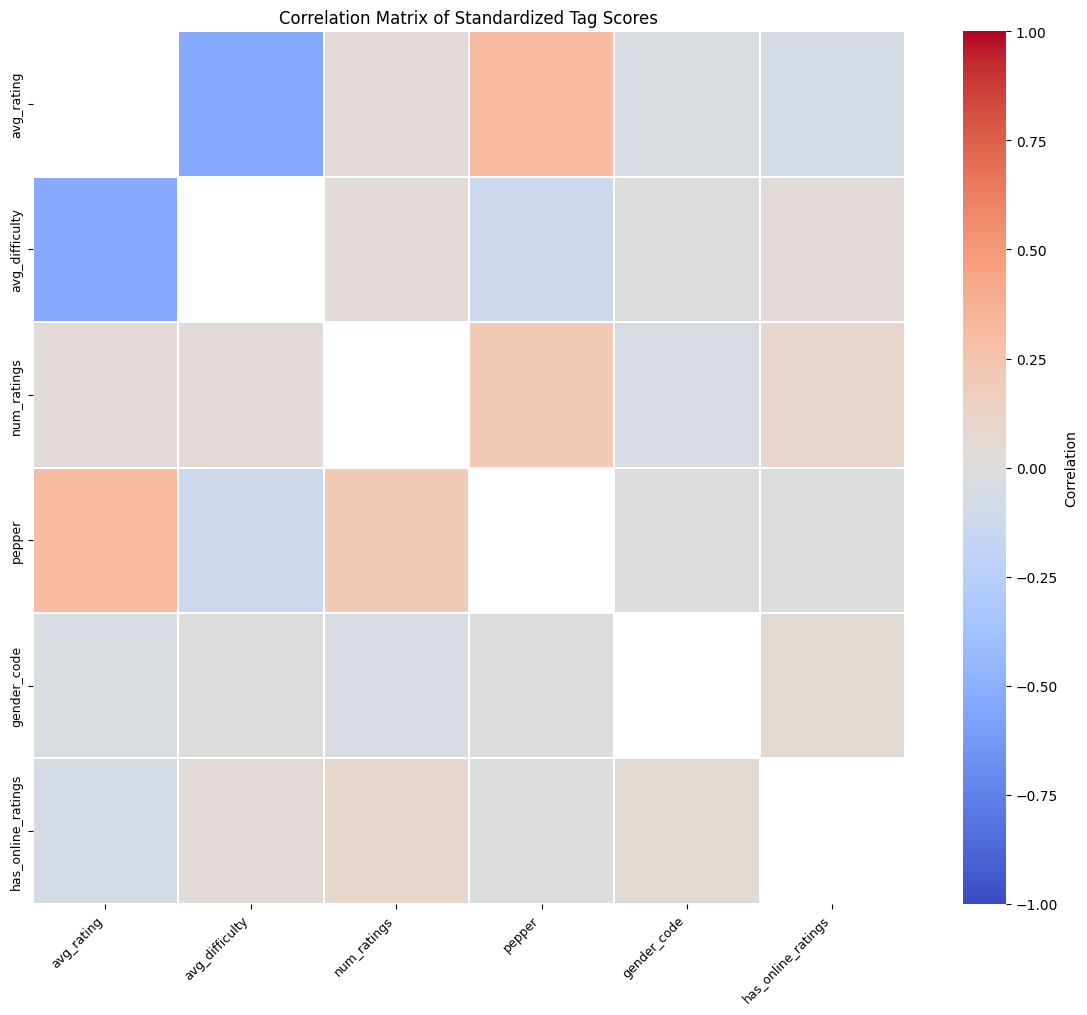

In [ ]:

n_before = len(d)
na_rows = d.isna().any(axis=1).sum()
print(f"Rows with >= 1 NA in tag cols: {na_rows} ({na_rows/n_before:.2%})")

scaler = StandardScaler()
d_scaled = scaler.fit_transform(d)

d_scaled_df = pd.DataFrame(d_scaled, columns=d.columns, index=prepared_df.index)

d = prepared_df[d.columns]

d_scaled = scaler.fit_transform(d)

d_scaled_df = pd.DataFrame(
    d_scaled,
    columns=d.columns,
    index=prepared_df.index
)

corr_matrix = d_scaled_df.corr()
diag_mask = np.eye(len(corr_matrix), dtype=bool)

plt.figure(figsize=(12, 10))
sns.heatmap(
    corr_matrix,
    mask=diag_mask,
    cmap="coolwarm",
    vmin=-1,
    vmax=1,
    center=0,
    square=True,
    linewidths=0.3,
    cbar_kws={"label": "Correlation"}
)

plt.xticks(rotation=45, ha="right", fontsize=9)
plt.yticks(fontsize=9)
plt.title("Correlation Matrix of Standardized Num Columns")
plt.tight_layout()
plt.show()


In [ ]:
pca = PCA(n_components=4)

Y = d_scaled_df['avg_rating']
X = d_scaled_df.drop(columns=['avg_rating'])

X_pca = pca.fit_transform(X)

X_pca_df = pd.DataFrame(
    X_pca,
    index=d_scaled_df.index,
    columns=[f"PC{i+1}" for i in range(X_pca.shape[1])]
)

df_pca = pd.concat([Y, X_pca_df], axis=1)
df_pca.head()


NameError: name 'cum_explained' is not defined

In [ ]:
loadings = pd.DataFrame(
    pca.components_.T,
    index=X.columns,   # original feature names
    columns=[f"PC{i+1}" for i in range(X_pca.shape[1])]
)

loadings.abs().sort_values('PC1', ascending=False).head(10)


,PC1,PC2,PC3,PC4
pepper,0.698703,0.190291,0.093856,0.198983
num_ratings,0.643178,0.307285,0.252926,0.200282
avg_difficulty,0.257338,0.618823,0.422705,0.486717
has_online_ratings,0.168221,0.651304,0.228802,0.679263
gender_code,0.060127,0.249455,0.834380,0.471171


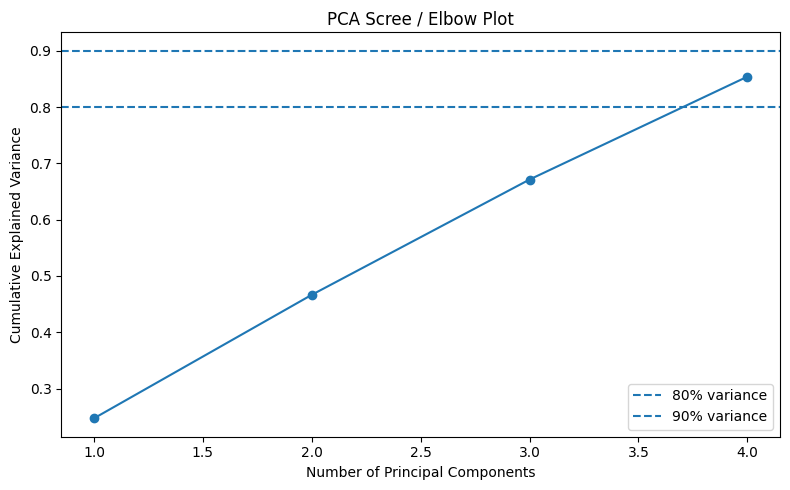

In [ ]:
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt

pca = PCA(n_components=4)
X_pca_full = pca.fit_transform(X)  # X = scaled predictors, no avg_rating

explained_var = pca.explained_variance_ratio_
cum_explained = np.cumsum(explained_var)

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(explained_var) + 1), cum_explained, marker='o')
plt.axhline(0.8, linestyle='--', label='80% variance')
plt.axhline(0.9, linestyle='--', label='90% variance')
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA Scree / Elbow Plot")
plt.legend()
plt.tight_layout()
plt.show()

# While PCA reduced multicollinearity, variance was distributed across several components, 
# indicating that multiple distinct dimensions contribute meaningfully to the data.

In [ ]:
k_folds = MODEL_HELPER.kfold_split()

model=LinearRegression()

res = MODEL_HELPER.cross_val_score(
    model,
    X=X, # X_pca_full[:-1]
    y=Y,
    kfolds=k_folds,
    scoring_methods=["rmse", "r2", "mae"]
)

In [ ]:
print(sum(res["rmse"]) / 5, np.var(res["rmse"], ddof=1), np.std(res["rmse"], ddof=1))
print(sum(res["r2"]) / 5, np.var(res["r2"], ddof=1), np.std(res["r2"], ddof=1))

0.8078423793411698 4.76989307115101e-05 0.006906441247959046
0.3473128453410922 3.476705795976987e-05 0.005896359721028719


In [ ]:
top_scores = {}

for i, f in enumerate(res["fitted_models"]):
    coefs = pd.Series(
        f.coef_,  # or pipeline.named_steps["lr"].coef_
        index=X.columns
    ).sort_values(key=np.abs, ascending=False)

    feat = coefs.head(5)
    top_scores[i] = feat

top_scores

{0: num_ratings          -0.386551
 avg_difficulty        0.298861
 pepper               -0.202846
 gender_code          -0.181744
 has_online_ratings    0.034090
 dtype: float64,
 1: num_ratings          -0.387444
 avg_difficulty        0.299174
 pepper               -0.203361
 gender_code          -0.178222
 has_online_ratings    0.030712
 dtype: float64,
 2: num_ratings          -0.388039
 avg_difficulty        0.298612
 pepper               -0.202069
 gender_code          -0.183598
 has_online_ratings    0.032430
 dtype: float64,
 3: num_ratings          -0.385679
 avg_difficulty        0.298750
 pepper               -0.201857
 gender_code          -0.180455
 has_online_ratings    0.031918
 dtype: float64,
 4: num_ratings          -0.388129
 avg_difficulty        0.298804
 pepper               -0.203114
 gender_code          -0.181106
 has_online_ratings    0.033078
 dtype: float64}

In [ ]:
coef_df = []

for fold, series in top_scores.items():
    tmp = series.reset_index()
    tmp.columns = ["feature", "coef"]
    tmp["abs_coef"] = tmp["coef"].abs()
    tmp["fold"] = fold
    coef_df.append(tmp)

coef_df = pd.concat(coef_df, ignore_index=True)
coef_df

summary = (
    coef_df
    .groupby("feature")
    .agg(
        mean_abs_coef=("abs_coef", "mean"),
        times_in_top5=("feature", "count")
    )
    .sort_values("mean_abs_coef", ascending=False)
)

summary

,mean_abs_coef,times_in_top5
feature,,
num_ratings,0.387168,5
avg_difficulty,0.298840,5
pepper,0.202649,5
gender_code,0.181025,5
has_online_ratings,0.032445,5
